# Playing Chess with SARFA-Saliency 


In [59]:
from chess_saliency import *
from sarfa_saliency import *

# Libraries for displaying board and saliency
from IPython.display import Image, display
import cairosvg
import svg_custom.svg_custom as svg_custom
import matplotlib.pyplot as plt
import cv2

# Few Utility Functions 
def svg_to_png(img):
    '''
    Converts given svg image to png
    Input : 
        img : image in .svg format 
    Output :
        board.png
        Display of image
    '''
    with open('board.svg', 'w+') as f:
        f.write(img)
    cairosvg.svg2png(url='board.svg', write_to='board.png')
    display(Image(filename='board.png'))

def display_board(board):
    '''
    Displaying given board
    Input : 
        board : chess.Board
    Output :
        board.png
        Display of image     
    '''
    img = svg_custom.board(board = board)
    svg_to_png(img)
    
def return_bestmove(board, eval_time = 6000):
    '''
    Returns and displays best move for a given chess position
    Input :
        board : chess.Board
    Output :
        bestmove : chess.Move 
    '''
    engine.position(board)
    bestmove =  engine.go(movetime=eval_time).bestmove
    print('Best move is', bestmove)
    
    svg_w_arrow = svg_custom.board(board, arrows = [svg_custom.Arrow(tail =  bestmove.from_square, head = bestmove.to_square, color = '#e6e600')])
    
    svg_to_png(svg_w_arrow)
    
    return bestmove

def explanation(board):
    '''
    Generates explanation of the best move for given board position using SARFA
    
    Input :
        board = chess.Board
    Output :
        
    '''
    
    # Evaluation of board position for best move
    evaluation = computeSaliency(chess.Board.fen(board))
    
    # Laying the saliency map over the board
    heatmap = np.zeros((8, 8))
    for position in evaluation:
        x, y = evaluation[position]['int']//8, evaluation[position]['int'] % 8
        heatmap[x, y] = evaluation[position]['saliency']
    heatmap = np.flipud(heatmap)
    

    #### Saliency map overlaid on board
    svg = svg_custom.board(board, arrows = [svg_custom.Arrow(tail =  bestmove.from_square, head = bestmove.to_square, color = '#e6e600')])

    with open('board.svg', 'w+') as f:
        f.write(svg)
    cairosvg.svg2png(url='board.svg', write_to='board.png')

    # original board as a numpy array
    board_array = cv2.imread('board.png')

    threshold = (100/256)*np.max(heatmap) # percentage threshold. Saliency values above this threshold won't be mapped onto board

    # Create bounding boxes with saliency colours for every square on chess board
    for i in range(0, 8, 1):
        for j in range(0, 8, 1):
            ii = 45*i+20
            jj = 45*j+20
            value_of_square =  heatmap[i, j]
            if value_of_square < threshold:
                continue
            for box_i in range(ii, ii+44, 1):
                for box_j in range(jj, jj+44, 1):
                    if box_i > ii+4 and box_i < ii+40 and box_j > jj+4 and box_j < jj+40:
                        continue
                    board_array[box_i, box_j, 0] = 256 - 0.8*256*heatmap[i, j]/(np.max(heatmap) + 1e-10)
                    board_array[box_i, box_j, 1] = 256 - 0.84*256*heatmap[i, j]/(np.max(heatmap) + 1e-10)
                    board_array[box_i, box_j, 2] = 256 - 0.19*256*heatmap[i, j]/(np.max(heatmap) + 1e-10)

    cv2.imwrite("board.png", board_array)
    print('------------===============------------===============')
    display(Image('board.png'))
    print('------------===============------------===============')

## Set up the game

You can setup the chess board using standard board editor like [Lichess Board Editor](https://lichess.org/editor) and copy the [FEN](https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation) of given position. 

**Note**:(For now, the code requires white to play. How to play with black then? You can always switch the colors in the editor.)

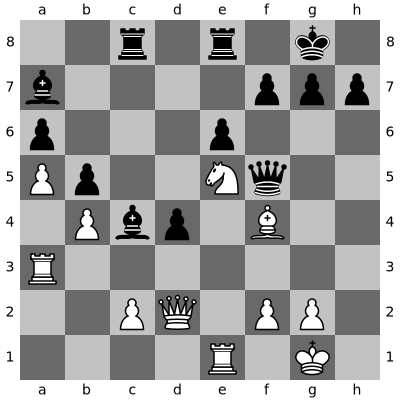

In [61]:
FEN = '2r1r1k1/b4ppp/p3p3/Pp2Nq2/1Pbp1B2/R7/2PQ1PP1/4R1K1 w - - 0 1'

# Visulaize the board
board = chess.Board(FEN)
display_board(board)

## What's the bestmove?

Best move is g2g4


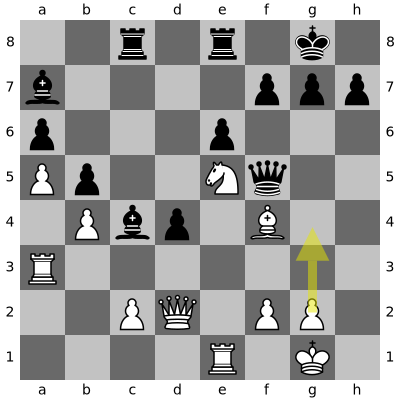

In [62]:
bestmove = return_bestmove(board)

# but WHY?

Let's use [SARFA](https://arxiv.org/abs/1912.12191)(Salient and Relevant Feature Attribution) to find out why this move is good for us. We get an image with important pieces behind the best move (See the output image).

*********************** 2r1r1k1/b4ppp/p3p3/Pp2Nq2/1Pbp1B2/R7/2PQ1PP1/4R1K1 w - - 0 1 **********************
querying engine with perturbed position
Total Legal Moves :  44
original move =  g2g4
perturbing square =  a1
square was empty, so skipped
------------------------------------------
perturbing square =  a2
square was empty, so skipped
------------------------------------------
perturbing square =  a3
querying engine with perturbed position
Total Legal Moves :  34
skipping original action for KL-Divergence
saliency for this square =  {'int': 16, 'saliency': 0.12725222676115888, 'dP': 0.07922689603928623, 'K': 0.3231183704346833, 'QMaxAnswer': 0, 'actionGapBeforePerturbation': 7.029999999999999, 'actionGapAfterPerturbation': 4.750000000000001}
------------------------------------------
perturbing square =  a4
square was empty, so skipped
------------------------------------------
perturbing square =  a5
querying engine with perturbed position
Total Legal Moves :  44
skipping origin

Total Legal Moves :  44
skipping original action for KL-Divergence
saliency for this square =  {'int': 60, 'saliency': 0.2496279305839356, 'dP': 0.14703200377851922, 'K': 0.8259796393605505, 'QMaxAnswer': 0, 'actionGapBeforePerturbation': 7.029999999999999, 'actionGapAfterPerturbation': 2.7300000000000004}
------------------------------------------
perturbing square =  f1
square was empty, so skipped
------------------------------------------
perturbing square =  f2
querying engine with perturbed position
Total Legal Moves :  43
skipping original action for KL-Divergence
saliency for this square =  {'int': 13, 'saliency': 0.4344099473210287, 'dP': 0.8687689675119268, 'K': 0.28961229055964854, 'QMaxAnswer': 1, 'actionGapBeforePerturbation': 7.029999999999999, 'actionGapAfterPerturbation': 0.8999999999999995}
------------------------------------------
perturbing square =  f3
square was empty, so skipped
------------------------------------------
perturbing square =  f4
querying engine wi

-----------------===============------------================


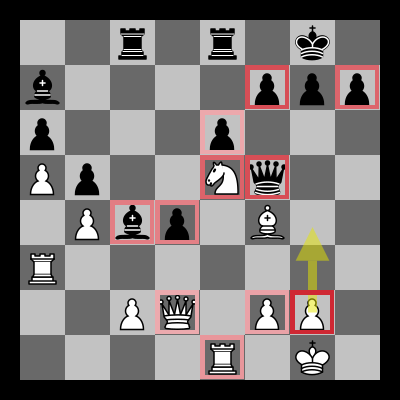

-----------------===============------------================


In [63]:
explanation(board)